## Feature Importance

In [1]:
# Importing all required packages and ignore warnings 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_recall_curve
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, brier_score_loss
import statsmodels.api as sm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
from sklearn.model_selection import train_test_split
from collections import Counter
from collections import OrderedDict
from itertools import islice
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from IPython.display import Markdown, display
import warnings
import time
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)
pd.options.display.max_colwidth = 100

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kshamajha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
review_df_final = pd.read_csv("reviews_dataset_new.csv")
review_df_final.shape

(437511, 23)

In [3]:
X = review_df_final.drop(['fake','ReviewText'],axis=1)
y = review_df_final['fake']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=100)
scaler = StandardScaler()
# Scale data for X
numeric_cols = X_train.select_dtypes([np.number]).columns
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
print(X_train.shape)
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])                        
print(X_test.shape)

# Print churn ratio in train data
print("Fake Ratio:")
y_train.value_counts()*100/y_train.size

(306257, 21)
(131254, 21)
Fake Ratio:


0    84.024855
1    15.975145
Name: fake, dtype: float64

In [4]:
### There is data imbalance. Let's use SMOTE to handle data imbalance

# Using SMOTE to handle data imbalance
counter = Counter(y_train)
print('Before', counter)
# Using SMOTE to handle imbalance in data
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)
counter = Counter(y_train)
print('After', counter)

Before Counter({0: 257332, 1: 48925})
After Counter({0: 257332, 1: 257332})


In [5]:
st = time.process_time()
modelXg = XGBClassifier(subsample = 0.6, n_estimators=200,min_child_weight=1, max_depth=10, learning_rate=0.3,
                           gamma=0.1, objective='binary:logistic')


modelXg.fit(X_train, y_train)
y_xg = modelXg.predict(X_test)
et = time.process_time()
res = et - st
print('CPU Execution time:', res, 'seconds')

[22:41:53] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU Execution time: 528.191884 seconds


In [6]:
# Determine whether your model is overfitting or not , with the help of ROC.                                                 
print(confusion_matrix(y_test, y_xg))
predictions = [value for value in y_xg]
accuracy = round(accuracy_score(y_test, predictions),2)
precision = round(precision_score(y_test, predictions),2)
recall = round(recall_score(y_test, predictions),2)
f1 = round(f1_score(y_test, predictions),2)
auc = round(roc_auc_score(y_test,y_xg), 2)

print("Accuracy_score: %.2f%% on test dataset" % (accuracy * 100.0))
print("precision_score: %.2f%% on test dataset" % (precision * 100.0))
print("recall_score: %.2f%% on test dataset" % (recall * 100.0))
print("f1_score: %.2f%% on test dataset" % (f1 * 100.0))
print("AUC_score: %.2f%% on test dataset" % (auc * 100.0))

[[109763    695]
 [  5291  15505]]
Accuracy_score: 95.00% on test dataset
precision_score: 96.00% on test dataset
recall_score: 75.00% on test dataset
f1_score: 84.00% on test dataset
AUC_score: 87.00% on test dataset


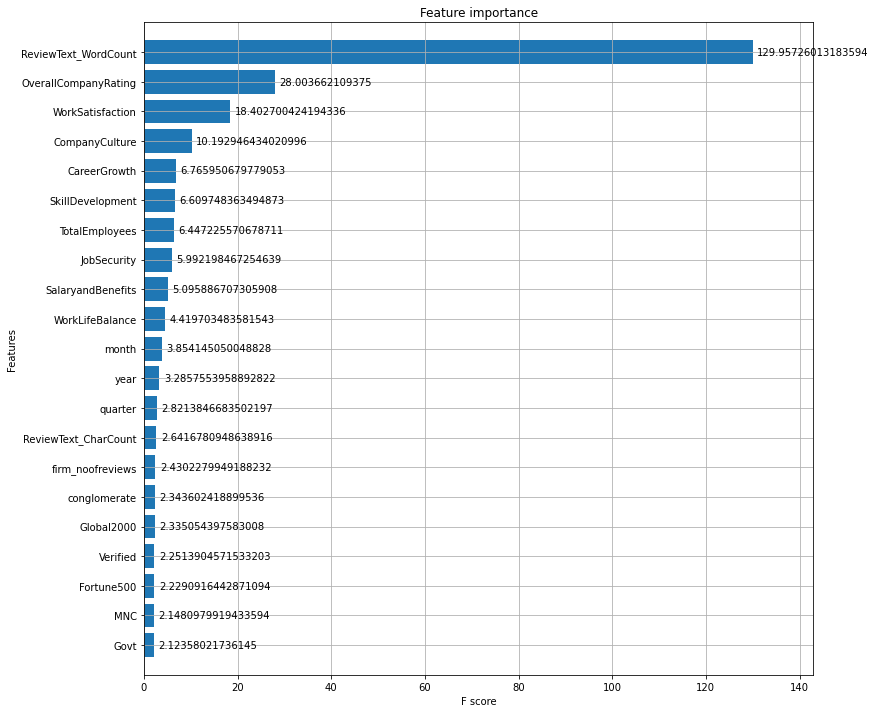

In [14]:
fig, ax = plt.subplots(figsize=(12,12))
plot_importance(modelXg,importance_type='gain', max_num_features=50, height=0.8, ax=ax)
plt.show()

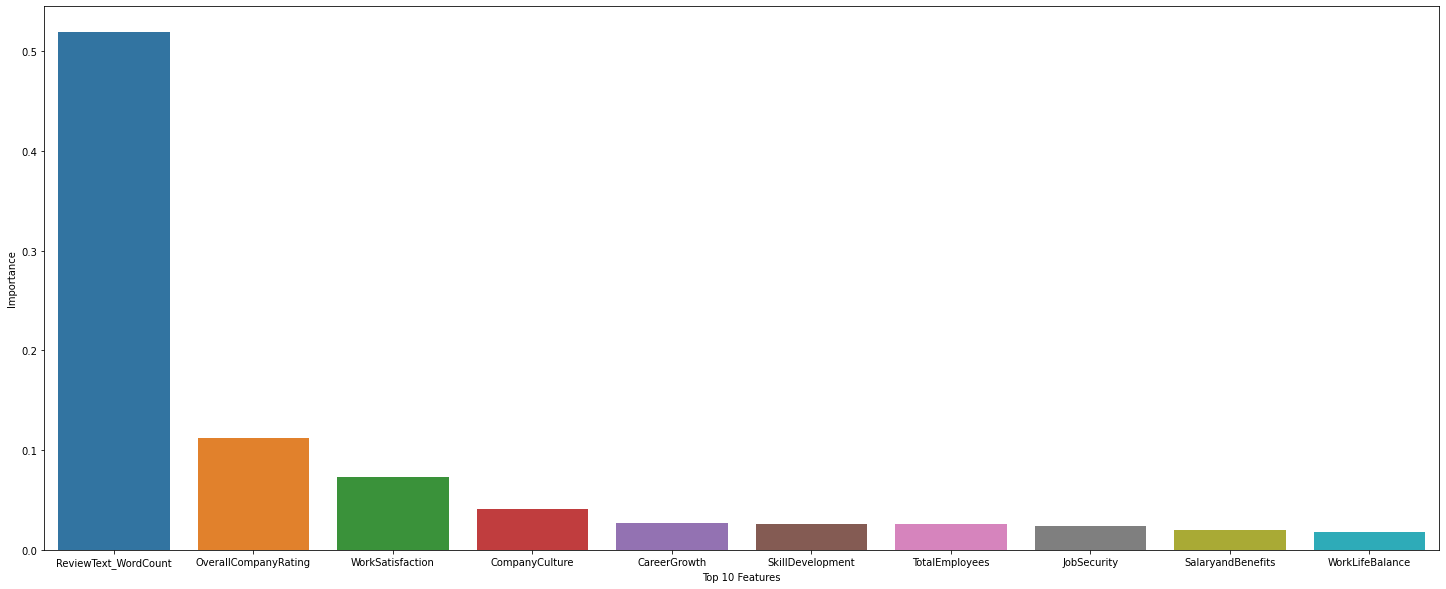

In [16]:
#plotting the top variables from company review dataset
imp=modelXg.feature_importances_
names=X_train.columns.values
imp,names=zip(*sorted(zip(imp,names)))

df_1=pd.DataFrame({"Variable":names,"importance":imp})
df_2 = df_1.sort_values(by="importance",axis=0,ascending=False)
df_2 = df_2.reset_index(drop=True)


plt.figure(figsize=(25, 10))

ax = sns.barplot(x='Variable', y= 'importance', data=df_2[0:10])
ax.set(xlabel = 'Top 10 Features', ylabel = 'Importance')
plt.show()

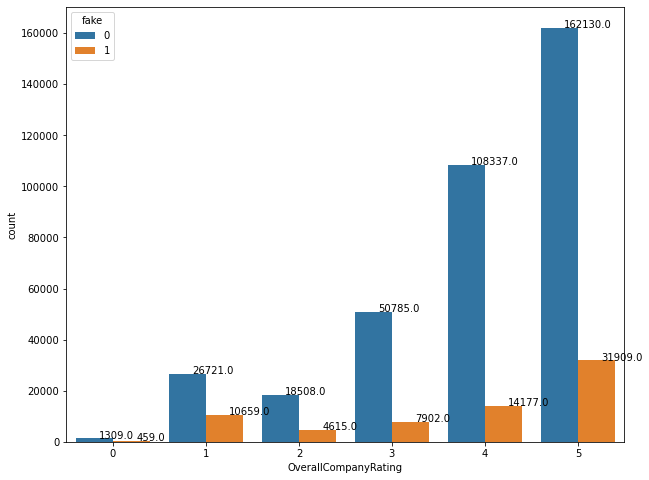

In [20]:
# Lets see how SalaryandBenefits and fake are in sync or it differs
plt.figure(figsize=(10,8))
ax = sns.countplot(x='OverallCompanyRating', hue="fake", data=review_df_final)
for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
plt.show()